### The German Traffic Sign Benchmark

Student Name 1: Panagiotis Michalopoulos

Student Name 2: Filip Finfando

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
import numpy as np
import cv2

IMG_HEIGHT = 600
#SIGN_SIZE = (224, 224)
SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt('./data/bin_labels_sorted.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [2]:
# use those numbers to change range in the next cell
! wc -l ./data/bin_labels_sorted.txt
! grep "00600.ppm" -B 5 -A 5 -m 1 bin_labels_sorted.txt --line-number

10213 ./data/bin_labels_sorted.txt
6848-00599.ppm;596;359;630;429;0
6849-00599.ppm;602;362;628;421;0
6850-00599.ppm;700;454;722;476;1
6851-00599.ppm;762;350;943;416;0
6852-00599.ppm;812;360;930;412;0
6853:00600.ppm;0;434;406;582;0
6854-00600.ppm;157;300;1020;600;0
6855-00600.ppm;1;423;97;512;0
6856-00600.ppm;2;420;158;518;0
6857-00600.ppm;458;423;476;452;0
6858-00600.ppm;494;427;518;453;0


In [3]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('../FullIJCNN2013', range(0,600), range(0,6852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('../FullIJCNN2013', range(600,900), range(6852,10213))

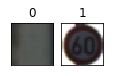

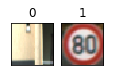

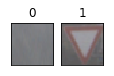

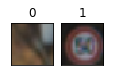

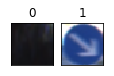

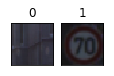

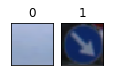

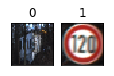

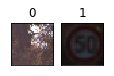

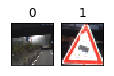

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)

for r in range(10):
    fig = plt.figure(figsize=(8,8))
    for i in range(num_classes):
        ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
        ax.set_title(class_names[i])
        indices = np.where(np.isin(train_labels, class_names[i]))[0]
        plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
    plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:6000]
tr_labels = np.array(train_labels)[0:6000]
va_signs = np.array(train_signs)[6000:6852]
va_labels = np.array(train_labels)[6000:6852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [6]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization

cnn = Sequential()
## If You preprocessed with gray scaling and local histogram equivalization then input_shape = (32,32,1) else (32,32,3)
cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
#cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
#cnn.add(Flatten())
cnn.add(GlobalAveragePooling2D())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(num_classes, activation='softmax'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxP

In [8]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

data = cnn.fit(tr_signs, tr_labels, batch_size=128, epochs=100, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard, early_stopping])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.cast instead.
Train on 6000 samples, validate on 852 samples
Epoch 1/100
 - 4s - loss: 0.3918 - acc: 0.8363 - val_loss: 0.4999 - val_acc: 0.8897
Epoch 2/100
 - 2s - loss: 0.1808 - acc: 0.9387 - val_loss: 0.1531 - val_acc: 0.9495
Epoch 3/100
 - 2s - loss: 0.1105 - acc: 0.9608 - val_loss: 0.3304 - val_acc: 0.9096
Epoch 4/100
 - 2s - loss: 0.0810 - acc: 0.9733 - val_loss: 0.1118 - val_acc: 0.9707
Epoch 5/100
 - 2s - loss: 0.0567 - acc: 0.9807 - val_loss: 0.0599 - val_acc: 0.9836
Epoch 6/100
 - 2s - loss: 0.0615 - acc: 0.9802 - val_loss: 0.0389 - val_acc: 0.9894
Epoch 7/100
 - 2s - loss: 0.0519 - acc: 0.9817 - val_loss: 0.3581 - val_acc: 0.9237
Epoch 8/100
 - 2s - loss: 0.0459 - acc: 0.9862 - val_loss: 0.0510 - val_acc: 0.9789
Epoch 9/100
 - 2s - loss: 0.0361 - acc: 0.9863 - val_loss: 0.0661 - val_acc: 0.9847
Epoch 10/100
 - 2s - loss: 0.0314 - acc: 0.9897 - val_loss: 0.1268 - val_acc: 0.9531
Epoch 11/100
 - 2s - loss: 0.0232 - acc: 0.9918 - val_loss: 0.02

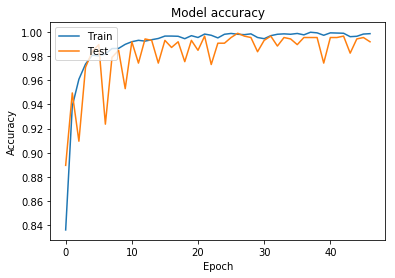

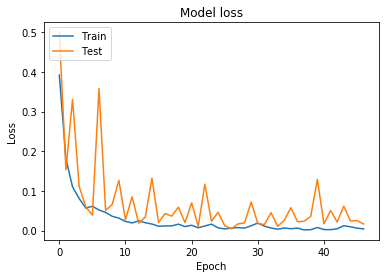

In [9]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
# serialize model to JSON
model_json = cnn.to_json()
with open("bin_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("bin_model.h5")
print("Saved model to disk")

Saved model to disk


In [11]:
# from keras.preprocessing.image import ImageDataGenerator

# print(len(tr_signs))
# tr_signs_aug = np.array(tr_signs, copy=True) 
# tr_labels_aug = np.array(tr_labels, copy=True)

# datagen = ImageDataGenerator(featurewise_center=False,
#                              featurewise_std_normalization=False,
#                              width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              zoom_range=0.2,
#                              shear_range=0.1,
#                              rotation_range=10.)

# datagen.fit(tr_signs_aug, augment=True)

# # Concatenating the old data with the augmented data
# tr_signs_aug  = np.concatenate((tr_signs, tr_signs_aug), axis=0)
# tr_labels_aug  = np.concatenate((tr_labels, tr_labels_aug), axis=0)

# print(len(tr_signs_aug))

# for x_batch, y_batch in datagen.flow(tr_signs_aug, tr_labels_aug, batch_size=9):
#     # create a grid of 3x3 images
#     fig = plt.figure(figsize=(6,6))
#     for i in range(0, 9):
#         ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
#         ax.set_title(np.argmax(y_batch[i]))
#         plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
#     # show the plot
#     plt.show()
#     break

# train_steps = int(len(tr_signs_aug) / 16)
# valid_steps = int(len(va_signs) / 16)
# data = cnn.fit_generator(datagen.flow(tr_signs_aug, tr_labels_aug, batch_size=16), epochs=100, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard, early_stopping])

# start = time()
# loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
# end = time()
# print('CNN took ' + str(end - start) + ' seconds')
# print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

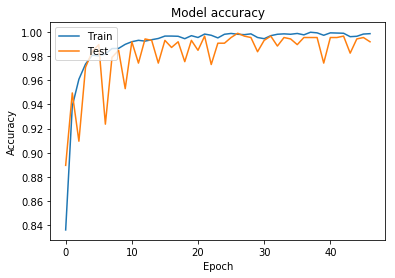

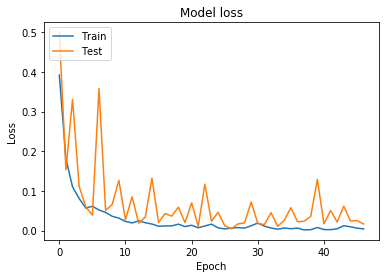

In [12]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()